In [78]:
# Dhananjay Tiwari,
# Graduate Student, Mechanical Engineering, Coordinated Science Laboratory, UIUC
# Created on : July 17, 2023
# This file implements clustering algorithm with inequality constraints

In [149]:
# import modules
import numpy as np # Computational python programming and not include this? Can't happen!
import matplotlib.pyplot as plt # module to make plots
from scipy.optimize import minimize # function to perform optimization
from functools import partial # to create functions with partial arguments
from scipy.optimize import SR1 # to approximate Hessians
from scipy.optimize import fsolve # to solve nonlinear equations
import time # to measure code runtime
from pylab import figure, cm # for visualizing 3D functions

In [80]:
# create FLP class and its associated functions
class FLP():
    # declare the class variables
    N : int # number of resources
    M : int # number of facilities
    d : int # dimension of the problem
    resLoc : np.ndarray # resource locations
    facLoc : np.ndarray # facility locations (initial)
    P : np.ndarray # association matrix between resources and facilities (P-probabilities)
    Phi : np.ndarray # probability array for inequality constraints getting satisfied (Phi-probabilities)
    ineq : str # identifier of type of inequality constraints

    # initialize the class variables
    def __init__(self, N, M, d, resLoc, facLoc, ineq):
        self.N = N
        self.M = M
        self.d = d
        self.resLoc = resLoc
        self.facLoc = facLoc
        self.P = np.ones([N, M])
        self.P = self.P / np.sum(self.P, axis = 1, keepdims=True) # normalize the P-probabilities
        self.Phi = np.ones([M, 1])*1e-5 # start with a small Phi-probabilities
        self.ineq = ineq
        print('================= Class FLP() initialized =================')

    # compute the association cost matrix between the resources and the facilities
    def association_cost_matrix(self, resLoc, facLoc, scaling_factor):
        '''
        input - self, the class instance
               resLoc: resource locations
               facLoc: facility locations
               scaling_factor: scaling factor to normalize distortion cost
        output - D: association cost matrix of size N x M
        '''
        # print('----- Inside association_cost_matrix() function -----')
        # initialize the association cost matrix
        D = np.zeros([self.N, self.M])

        tileX = np.kron(np.ones([1,self.M]), resLoc)
        flatY = facLoc.reshape([1,self.d*self.M])
        P = tileX - flatY
        Q = np.array(np.array_split(P, self.M, axis = 1))
        D = np.transpose(np.linalg.norm(Q, axis = 2))/scaling_factor
        # print('facLoc = ', facLoc)
        # print('D = ', D[2, :])

        return D
    
    # compute the set of all inequality constraint functions
    def ineq_cons(self, num_ineq, facLoc, P):
        '''
        input - self: the class instance
                facLoc: facility locations
                string: name of inequality constraints
                P : P-probabilities
        output - vec_ineq: a vector of inequality constraints of the form - vec_ineq <= 0
                 figures: inequality constraint data for plotting 
        '''
        # initialize the inequality constraint vectors
        # num_ineq = self.M
        vec_ineq = np.zeros([num_ineq, 1])
        # circular inequality constraint
        if 'circles' == self.ineq:        
            centers = np.array([[-5,0], [15,20], [-20,-15], [-25,25]])
            radii = np.array([1,1,1,1])*3
            vec_ineq = radii - np.linalg.norm(facLoc - centers, axis = 1)
            figures = ['circles', centers, radii]
        elif 'circles1' == self.ineq:        
            centers = np.array([[-20,0], [20,0]])
            radii = np.array([1,1])*2
            vec_ineq = radii - np.linalg.norm(facLoc - centers, axis = 1)
            figures = ['circles1', centers, radii]
        
        return vec_ineq, figures

    # compute the vector of cluster mass inequality constraints
    def cluster_mass_cons(self, P, C, rho, num_ineq):
        ''' 
        input - P : the probability association matrix
                C : the capacity on the facilities
                rho : resource weights
                num_ineq : the total number of inequality constraints
        output - g : vector of all the inequality constraints
        '''
        # print('inside cluster_mass_cons')
        zeta = np.zeros(num_ineq)
        # print('C = ' , C)
        # print('rho = ' , rho)
        # print('P-Probability = ', P)
        C_from_P = np.reshape(np.dot(np.transpose(P), rho), (1, num_ineq))
        # print('rho shape = ', np.shape(rho))
        # print('P shape = ', np.shape(P))
        # print('C_from_P shape = ', np.shape(C_from_P))
        zeta = C_from_P - C
        # print('C_from_P = ' , C_from_P)

        return zeta

    # compute the probability associations using gibbs distribution
    def gibbs_associations(self, facLoc, P, beta, gamma, Lambda, rho, R, C, num_ineq, D_scaling):
        '''
        input - facLoc : facility locations
                P : P-probabilities (results in implicit equations to compute P-probabilities)
                beta : annealing parameter
                gamma : inequality constraint shaping parameter
                Lambda : inequality constraint Lagrangian constants
                rho : resource weights
                R : gradient of inequality constraint w.r.t. P-probabilities
                C : capacity constraints
                num_ineq : number of inequality constraints
                D_scaling : scaling factor to normalize distortion cost
        output - Phi : Phi-probabilities
                 P : P-probabilities
        '''
        # print('----- Inside gibbs_associations() function -----')
        # store side variables/diagnosis variables as a dictionary
        side_vars = {}
        # first compute Phi-probabiltiies
        # zeta, nouse = self.ineq_cons(self.M, facLoc, P)
        zeta = self.cluster_mass_cons(P, C, rho, num_ineq) # inequality vectors, size : 1 x num_ineq
        # print('zeta shape = ', np.shape(zeta))
        ineq_exp_term = np.exp(np.minimum(700, -beta * np.multiply(Lambda, np.tanh(gamma*zeta)))) # size : 1 x num_ineq
        Phi = ineq_exp_term / (1 + ineq_exp_term) # size : 1 x M
        # Phi = 1 / (1 + np.exp(beta * np.multiply(Lambda, np.tanh(gamma*zeta))))
        # then compute P-probabilities
        D = self.association_cost_matrix(self.resLoc, facLoc, D_scaling) # size : N x M
        # print('D = ', D[2, :])
        Lambda_tile = np.kron(np.ones([self.N, 1]), Lambda) # size : N x M
        rho_tile = np.kron(np.ones([1,self.M]), rho) # size : N x M
        Phi_tile = np.kron(np.ones([self.N, 1]), Phi) # size : N x M
        sech_term = np.kron(np.ones([self.N, 1]), 1/np.cosh(np.maximum(-100, np.minimum(100, gamma*zeta)))**2) # size : N x M
        D_eff = D + gamma*np.multiply(
            np.divide(Lambda_tile, rho_tile),
            np.multiply(Phi_tile, np.multiply(R, sech_term))
            ) # size : N x M
        D_eff_min = np.min(D_eff, axis=1, keepdims=True)
        exp_term = np.exp(-beta*(D_eff - D_eff_min))
        # exp_term = np.maximum(1e-40, np.exp(np.minimum(700, -beta * D_eff))) # size : N x M
        sum_exp_term = np.kron(np.ones([1, self.M]), 
                               np.sum(exp_term, axis = 1, keepdims=True)) # size : N x M
        P = exp_term/sum_exp_term # size : N x M

        # define diagnosis variable
        side_vars['D']   = D
        side_vars['zeta'] = zeta
        side_vars['Lambda_tile'] = Lambda_tile
        side_vars['rho_tile'] = rho_tile
        side_vars['Phi_tile'] = Phi_tile
        side_vars['sech_term'] = sech_term
        side_vars['D_eff'] = D_eff
        side_vars['D_eff_min'] = D_eff_min
        side_vars['exp_term'] = exp_term
        side_vars['sum_exp_term'] = sum_exp_term

        return Phi, P, side_vars
    
    # compute free energy
    def free_energy(self, facLoc, P, beta, gamma, Lambda, R, rho, D_scaling, C, num_ineq, pick_term):
        '''
        input - facLoc : numpy array of facility locations from previous annealing iteration
                P : P-probability matrix from previous annealing iteration
                beta : annealing parameter
                gamma : inequality constraint annealing parameter
                Lambda : inequality constraint Lagrangian constants
                xi : constant to approximate tanh with sign function
                R : gradient of inequality constraint w.r.t. P-probabilities
                rho : weights given to resources
                D_scaling : scaling factor to normalize distortion cost
                pick_term : decides which terms are zero/non-zero in the final free energy expression
        output - F : the free energy cost
        '''
        # print('----- inside free_energy() function -----')
        t1 = time.time()
        F = 0 # initialize the free energy cost
        T1 = 0; T2 = 0; T3 = 0 # the four terms in free energy expression
        # solve for the probability matrices
        Phi, P, side_vars = self.gibbs_associations(facLoc, P, beta, gamma, Lambda, rho, R, C, num_ineq, D_scaling) # size Phi : 1 x M, size P : N x M
        # get association cost matrix
        D = side_vars['D'] # self.association_cost_matrix(self.resLoc, facLoc, D_scaling) # size : N x M
        zeta = self.cluster_mass_cons(P, C, rho, num_ineq)
        Lambda_tile = side_vars['Lambda_tile']
        rho_tile = side_vars['rho_tile']
        Phi_tile = side_vars['Phi_tile']
        sech_term = np.tile(1/np.cosh(np.maximum(-100, np.minimum(100, gamma*zeta)))**2, (self.N, 1))
        # print('sech_term = ', sech_term[2])
        # print('D = ', D[2,:])
        D_eff = D + gamma*np.multiply(
            np.divide(Lambda_tile, rho_tile), 
            np.multiply(Phi_tile, np.multiply(R, sech_term))
            ) # size : N x M
        # print('D_eff = ', D_eff[2, :])
        # print('D residue = ', D_eff[2,:] - D[2,:])
        min_D_eff = np.min(D_eff, axis = 1, keepdims=True)
        exp_term = np.exp(-beta * (D_eff - min_D_eff))
        # print('exp_term exponent = ' , -beta * (D_eff - min_D_eff)[2,:])
        # print('exp_term = ' , np.exp(-beta * (D_eff - min_D_eff)[2,:]))
        # exp_term = np.maximum(1e-40, np.exp(np.minimum(700, -beta * D_eff))) # size : N x M
        sum_exp_term = np.sum(exp_term, axis = 1, keepdims=True) # size : N x 1
        # print('sum_exp_term = ', sum_exp_term[2, :])
        # print("zeta=" , zeta, " Phi=", Phi)
        # ineq_exp_term = np.exp(beta * Lambda * np.tanh(gamma*zeta))
        # print('ineq_exp_term = ' , ineq_exp_term)
        ineq_exp_term = np.exp(np.minimum(100, -beta * np.multiply(Lambda, np.tanh(gamma*zeta)))) # size : 1 x M
        t2 = time.time()
        # print('time taken for matrix computation and tiling = ', t2 - t1)
        # print('time taken for matrix computation w/o tiling = ', t2 - t_tile)
        t3 = time.time()
        # term 1 : inequality sec hyperbolic
        T1 = -gamma * np.sum(np.dot(
            np.multiply(Phi, np.multiply(Lambda, 1/np.cosh(np.maximum(-100, np.minimum(100, gamma*zeta)))**2)), 
            np.multiply(R, P).T)
            )
        t4 = time.time()
        # print('time taken for T1 computation = ', t4 - t3)
        # term 2 : beta log sum exp
        T2 = -1/beta * np.dot(rho.T, np.log(sum_exp_term) - beta*min_D_eff)[0,0]
        t5 = time.time()
        # print('time taken for T2 computation = ', t5 - t4)
        # term 3 : gamma log sum exp
        T3 = -1/beta * np.sum(np.log(ineq_exp_term + 1) - beta * Lambda * np.tanh(gamma*zeta))
        t6 = time.time()
        # print('time taken for T3 computation = ', t6 - t5)

        F = np.dot(np.array([T1, T2, T3]), pick_term)
        
        return F

    # objective function as a function of one-dimensional array of facility locations
    def objective(self, y, P, beta, gamma, Lambda, R, rho, D_scaling, C, num_ineq, pick_term):
        '''
        input - y : facility locations, size : 1 x 2*M
                P : P-probabilities
                beta : annealing parameter
                gamma : inequality constraint annealing parameter
                Lambda : inequality constraint Lagrangian constants
                xi : constant to approximate tanh with sign function
                R : gradient of inequality constraint w.r.t. P-probabilities
                rho : weights given to resources
                D_scaling : scaling factor to normalize distortion cost
                C : capacity constraint array
                num_ineq : number of inquality constraints
                pick_term : pick terms in the free energy
        output - free energy cost
        '''
        # print('----- Inside objective() function -----')
        return self.free_energy(y.reshape((self.M, self.d)), P,
                                beta, gamma, Lambda, R, rho, D_scaling,
                                C, num_ineq, pick_term)


In [81]:
# define functions to assist the implementation

# function to initialize various testcases
def testcases(tc_name):
    ''' 
    input - tc_name: name of the testcase
    output - N: number of resources
             M: number of facilities
             resLoc: resource locations
             facLoc: facility locations (initial)
    '''
    if 'small_tc_160_4' == tc_name :
        d = 2 # dimension of the coordinates
        N = 160 # number of resources
        M = 4 # number of facilties
        mean = [np.array([-5,0]), np.array([15,20]), np.array([-20,-15]), np.array([-25,25])] # cluster means
        cov = [np.array([[5, 0],[0, 5]])*3,
               np.array([[5, 0],[0, 5]])*3,
               np.array([[5, 0],[0, 5]])*3,
               np.array([[5, 0],[0, 5]])*3] # cluster covariances
        split = np.array([48, 32, 36, 44]) # no of points in every cluster
        C = np.array([40, 32, 30, 20])*0.01 # the capacity of the clusters; C <= split
        resLoc = np.zeros([N, d]) # initialize resource locations
        res_mean = np.zeros([len(mean), d]) # initialize resource mean locations
        rho = np.ones([N,1])/N # resource weights/ uniform for now
        facLoc = np.tile(np.sum(resLoc*rho, axis=0)/N, (M,1)) # initialize facility locations at the centroid
        # generate resource and facility locations using normal distribution
        cnt = 0
        for i in range(len(mean)):
            resLoc[cnt:cnt+split[i], :] = np.random.multivariate_normal(mean[i], cov[i], split[i])
            res_mean[i,:] = np.sum(resLoc[cnt:cnt+split[i], :], axis=0)/len(resLoc[cnt:cnt+split[i], :])
            cnt = cnt + split[i]
    elif 'small_tc_320_8' == tc_name :
        d = 2 # dimension of the coordinates
        N = 320 # number of resources
        M = 8 # number of facilties
        mean = [np.array([-5,0]), np.array([15,20]), np.array([-20,-15]), np.array([-25,25]),
                np.array([15,0]), np.array([-15,-30]), np.array([40,15]), np.array([25,-25])] # cluster means
        cov = [np.array([[5, 0],[0, 5]])*3,
               np.array([[5, 0],[0, 5]])*3,
               np.array([[5, 0],[0, 5]])*3,
               np.array([[5, 0],[0, 5]])*3,
               np.array([[5, 0],[0, 5]])*3,
               np.array([[5, 0],[0, 5]])*3,
               np.array([[5, 0],[0, 5]])*3,
               np.array([[5, 0],[0, 5]])*3] # cluster covariances
        split = np.array([48, 32, 36, 44, 48, 32, 36, 44]) # no of points in every cluster
        C = np.array([48, 32, 36, 44, 48, 32, 36, 44]) # the capacity of the clusters; C <= split
        resLoc = np.zeros([N, d]) # initialize resource locations
        res_mean = np.zeros([len(mean), d]) # initialize resource mean locations
        rho = np.ones([N,1])/N # resource weights/ uniform for now
        facLoc = np.tile(np.sum(resLoc*rho, axis=0)/N, (M,1)) # initialize facility locations at the centroid
        # generate resource and facility locations using normal distribution
        cnt = 0
        for i in range(len(mean)):
            resLoc[cnt:cnt+split[i], :] = np.random.multivariate_normal(mean[i], cov[i], split[i])
            res_mean[i,:] = np.sum(resLoc[cnt:cnt+split[i], :], axis=0)/len(resLoc[cnt:cnt+split[i], :])
            cnt = cnt + split[i]
    elif 'small_tc_43_2' == tc_name :
        d = 2 # dimension of the coordinates
        N = 43 # number of resources
        M = 2 # number of facilties
        mean = [np.array([-15,0]), np.array([15,0])] # cluster means
        cov = [np.array([[5, 0],[0, 5]])*3,
               np.array([[5, 0],[0, 5]])*3] # cluster covariances
        split = np.array([21, 22]) # no of points in every cluster
        C = np.array([21, 15]) # the capacity of the clusters; C <= split
        resLoc = np.zeros([N, d]) # initialize resource locations
        res_mean = np.zeros([len(mean), d]) # initialize resource mean locations
        rho = np.ones([N,1])/N # resource weights/ uniform for now
        facLoc = np.tile(np.sum(resLoc*rho, axis=0)/N, (M,1)) # initialize facility locations at the centroid
        # generate resource and facility locations using normal distribution
        cnt = 0
        for i in range(len(mean)):
            resLoc[cnt:cnt+split[i], :] = np.random.multivariate_normal(mean[i], cov[i], split[i])
            res_mean[i,:] = np.sum(resLoc[cnt:cnt+split[i], :], axis=0)/len(resLoc[cnt:cnt+split[i], :])
            cnt = cnt + split[i]

    return N, M, d, resLoc, facLoc, res_mean, C, rho

# function to plot FLP results
def plot_flp(flp, N, M, resLoc, res_means, facLoc0, facLoc_opt):
    ''' 
    input - flp : the class instance
            N : # resources
            M : # facilities
            resLoc : resource locations
            facLoc0 : initial facility locations
            facLoc_opt : final facility locations (supposedly optimal)
            ineq_figures : data for plotting inequality constraints, datatype is variable
    output: None
    '''
    # initialize figure
    figure, axes = plt.subplots()
    # resources locations
    plt.scatter(resLoc[:, 0], resLoc[:, 1], marker = ".", color = 'orange')
    # resource means
    plt.scatter(res_means[:, 0], res_means[:, 1], marker = ".", color = 'red')
    # initial facility locations
    plt.scatter(facLoc0[:, 0], facLoc0[:, 1], marker = "+", color = 'blue')
    # final facility locations
    plt.scatter(facLoc_opt[:, 0], facLoc_opt[:, 1], marker = "+", color = 'black')
    plt.title('Facility and resource locations - N = ' + str(N) + ', M = ' + str(M))
    # plt.legend(['resources', 'cluster means', 'initial facilities', 'optimal facilities'])

    plt.grid()
    plt.show()
    return None

# function to plot the inequality constraints
def plot_capacity_constr(flp, P, C, rho, num_ineq):
    '''
    input - flp : flp class instance
            P : P-probability matrix
            C : array of capacity constraints
            rho : resource weights
            num_ineq : the number of inequality constraints
    output - None
    '''
    zeta = flp.cluster_mass_cons(P, C, rho, num_ineq)
    # initialize figure
    figure, axes = plt.subplots()
    # plot the zeta values (they all should be less than zero)
    plt.plot(np.arange(num_ineq).reshape([1,num_ineq])[0,:], zeta[0,:], 
             marker=".", color='black')
    plt.plot(np.arange(num_ineq).reshape([1,num_ineq])[0,:], 0*zeta[0,:], 
             marker=".", color='red')
    plt.title('The black line should remain below the red plot')
    plt.xlabel('constraint indices')
    plt.ylabel('zeta values')
    plt.grid()
    plt.show()
    return None


In [82]:
# implement the FLP algorithm on a 2D example problem
print(' ================ Small Testcase 1 ================ ')
N, M, d, resLoc, facLoc0, res_means, C, rho = testcases('small_tc_160_4')
centroid = np.sum(resLoc, axis = 0)/len(resLoc)
ineq = 'circles1'
print('centroid = ' , centroid)


 ================ Small Testcase 1 ================ 
centroid =  [-9.67789208  7.2992177 ]


In [86]:
# initialize the FLP class
flp = FLP(N, M, d, resLoc, facLoc0, ineq)

# Initialize the annealing parameters/constants/weights
# generate sequence of annealing parameters
# numBeta = 15; beta0 = 1e-7; rBeta = 5 # total number of beta iterations, initial beta, geometric ratio
# Beta = [beta0 * rBeta ** i for i in range(numBeta)] # sequence of beta-parameters
# numGamma = 7; gamma0 = 1e-2; rGamma = 3 # total number of beta iterations, initial beta, geometric ratio
# Gamma = [gamma0 * rGamma ** i for i in range(numGamma)] # sequence of beta-parameters
# create a beta-gamma curve
# curve = np.array([[0.000001, 0.0001],[0.000005, 0.0001],
#                    [0.00001, 0.0001],[0.00005, 0.0001],
#                    [0.00001, 0.0001],[0.00005, 0.0001],
#                    [0.0001, 0.0001],[0.0005, 0.0001],
#                    [0.0007, 0.0001],[0.001, 0.0001],
#                    [0.005, 0.0001],[0.01, 0.0001],
#                    [0.03, 0.0001],[0.08, 0.0001],
#                    [0.1, 0.0001],[0.3, 0.0001],
#                    [0.5, 0.0001],[0.7, 0.0001],
#                    [1, 0.0001],[3, 0.0001],
#                    [3, 0.0005],[3, 0.001],
#                    [3, 0.005],[3, 0.01],
#                    [3, 0.05],[3, 0.09],
#                    [3, 0.17],[3, 0.5],
#                    [6, 0.5],[6, 1],
#                    [6, 1.5],[6, 3],
#                    [30, 3],[50, 3],
#                    [70, 3],[70, 5],
#                    [100, 6],[100, 10]
#                 ])
curve1 = np.array([[0.000001, 0.0001],[0.000005, 0.0001],
                   [0.00001, 0.0001],[0.00005, 0.0001],
                   [0.00001, 0.0001],[0.00005, 0.0001],
                   [0.0001, 0.0001],[0.0005, 0.0001],
                   [0.0007, 0.0001],[0.001, 0.0001],
                   [0.005, 0.0001],[0.01, 0.0001],
                   [0.03, 0.0001],[0.08, 0.0001],
                   [0.1, 0.0001],[0.3, 0.0001],
                   [0.5, 0.0001],[0.7, 0.0001],
                   [1, 0.0001],[3, 0.0001],
                   [3, 0.0005],[3, 0.001],
                   [3, 0.005],[3, 0.01],
                   [3, 0.05],[3, 0.09],
                   [3, 0.17],[3, 0.5],
                   [6, 0.5],[6, 1],
                   [6, 1.5],[6, 3],
                   [30, 3],[50, 3],
                   [70, 3],[70, 5],
                   [100, 6],[100, 10]
                ])*10
# print('beta = ', Beta)
# print('gamma = ', Gamma)
num_ineq = M # the number of inequality constraints
Lambda = np.ones([1,num_ineq])*10 # inequality term penalty coefficients
R = np.ones([N, M]) # gradient of inequalities w.r.t. probability associations
D_scaling = 0.01 # scaling factor to normalize distortion cost
zeta = flp.cluster_mass_cons(
    flp.gibbs_associations(
        facLoc0, flp.P, curve1[0,0], curve1[0,1], Lambda, rho, R, C, num_ineq, D_scaling
        )[1], 
    C, rho, num_ineq) # initial inequality constraint vector


================= Class FLP() initialized =================


In [89]:
# Annealing
y = facLoc0.reshape(flp.d*flp.M) # initial facility locations
P0 = flp.P

# check class functions here
# print(facLoc0)
# ------------------------------------ 
#  beta =  60.0 gamma =  15.0
# facloc= [[ -5.25398907   3.91706783]
#  [-19.3062156   30.61654052]
#  [ -0.49327329   3.28518909]
#  [-20.70646966 -15.61816684]]
# zeta= [[-0.2125 -0.045   0.0125  0.025 ]]  Phi= [[5.08731208e-049 1.00000000e+000 1.00000000e+000 2.67898209e-261]]
# facLoc0 = np.array([[-5.25398907, 3.91706783],
#                     [-19.3062156, 30.61654052],
#                     [ -0.49327329, 3.28518909],
#                     [-20.70646966, -15.61816684]])
# beta=60
# gamma=15
# Phi, P, side_vars = flp.gibbs_associations(facLoc0, flp.P, beta, gamma, Lambda, 
#                                            rho, R, C, num_ineq, D_scaling)
# zeta=flp.cluster_mass_cons(flp.P, C, rho, num_ineq)
# print("zeta=", zeta)
# print("Phi=", Phi)
for curve in curve1:
    beta, gamma = curve[0], curve[1]
    # optimize free energy w.r.t. facility locations
    print('\n ------------------------------------ \n', 'beta = ', beta, 'gamma = ' , gamma)
    # print('beta = ', beta, 'gamma = ' , gamma)
    # using Powell method
    res = minimize(flp.objective, y, method='powell',
              args=(flp.P, beta, gamma, Lambda, R, rho, D_scaling, C, num_ineq, np.array([1, 1, 1])),
              options={'xtol':1e-8, 'disp':0})
    # using Trust-constr method
    # res = minimize(flp.objective, y, method='trust-constr', jac = '2-point', hess=SR1(),
    #               args=(flp.P, beta, gamma, Lambda, R, rho, D_scaling, C, num_ineq, np.array([1, 1, 1])),
    #               options={'xtol':1e-8, 'disp':0})
    # update facility locations and probability associations
    y = res['x'] + np.random.multivariate_normal(np.zeros(flp.M*flp.d), 0.0001*np.eye(flp.M*flp.d))
    # print('facLoc = ', y)
    flp.facLoc = y.reshape((flp.M, flp.d))
    flp.Phi, flp.P, diagnosis = flp.gibbs_associations(flp.facLoc, flp.P, beta, gamma, Lambda, rho, R, C, num_ineq, D_scaling)
    zeta = flp.cluster_mass_cons(flp.P, C, rho, num_ineq)
    print("facloc=", flp.facLoc)
    print("zeta=" , zeta, " Phi=", flp.Phi)
    # plot_flp(flp, N, M, resLoc, res_means, facLoc0, y.reshape((M, d)))
    # print('facloc shape = ' , np.shape(flp.facLoc))
    # print('diagnosis D_eff = ' , diagnosis['D_eff'][2, :])
    # print('diagnosis D_eff_min = ' , diagnosis['D_eff_min'][2, :])
    # print('diagnosis exp_term = ', diagnosis['exp_term'][2, :])
    # print('diagnosis sum_exp_term = ', diagnosis['sum_exp_term'][2, :])



 ------------------------------------ 
 beta =  9.999999999999999e-06 gamma =  0.001
facloc= [[-7.97715497  3.55298035]
 [-7.97058597  3.54296799]
 [-7.96858827  3.51487617]
 [-7.96618433  3.54744967]]
zeta= [[-0.15 -0.07 -0.05  0.05]]  Phi= [[0.50000001 0.5        0.5        0.5       ]]

 ------------------------------------ 
 beta =  5e-05 gamma =  0.001
facloc= [[-8.01662695  3.53358054]
 [-8.004115    3.53536934]
 [-7.97738995  3.54055897]
 [-7.98034256  3.55411332]]
zeta= [[-0.15000001 -0.06999999 -0.04999999  0.05      ]]  Phi= [[0.50000002 0.50000001 0.50000001 0.49999999]]

 ------------------------------------ 
 beta =  0.0001 gamma =  0.001
facloc= [[-7.99190149  3.54419704]
 [-7.98093617  3.54717065]
 [-8.00243827  3.54028717]
 [-7.98152272  3.54195713]]
zeta= [[-0.15 -0.07 -0.05  0.05]]  Phi= [[0.50000004 0.50000002 0.50000001 0.49999999]]

 ------------------------------------ 
 beta =  0.0005 gamma =  0.001
facloc= [[-7.97469064  3.53099459]
 [-7.99419005  3.54642254]
 

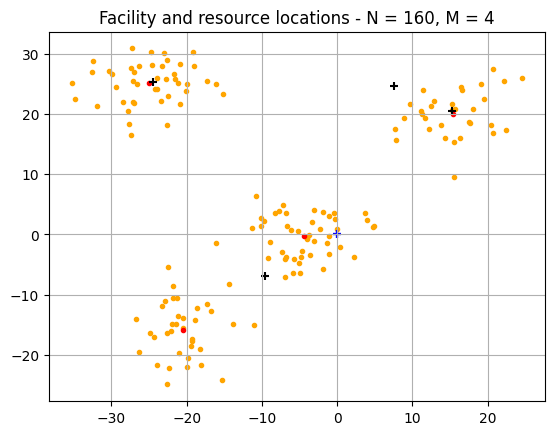

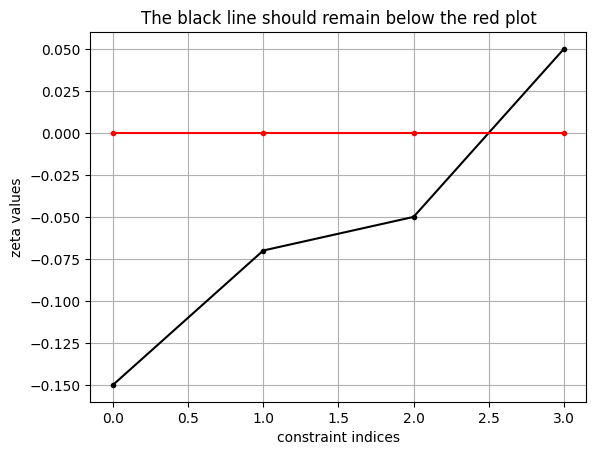

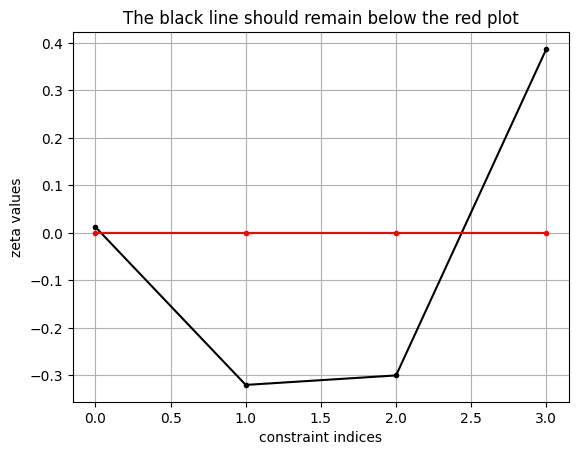

Phi-probabilities =  [[1. 1. 1. 0.]]


In [85]:
# Make the plots
plot_flp(flp, N, M, resLoc, res_means, facLoc0, y.reshape((M, d)))
plot_capacity_constr(flp, P0, C, rho, num_ineq)
plot_capacity_constr(flp, flp.P, C, rho, num_ineq)
# plot_multiple_capacity_constr(Zetas)
print('Phi-probabilities = ', flp.Phi)
# plt.plot(np.reshape(flp.P, flp.M*flp.N))
# plt.grid()
# plt.show()


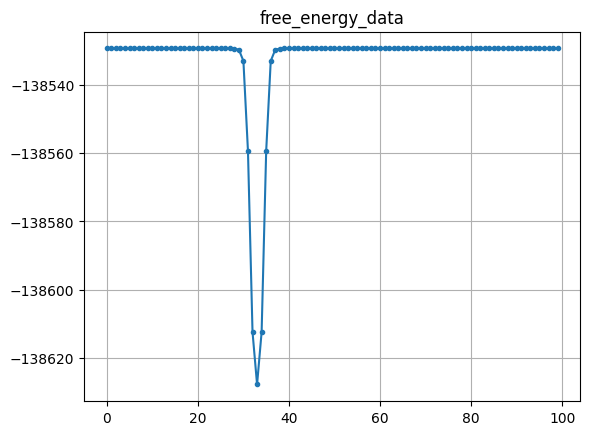

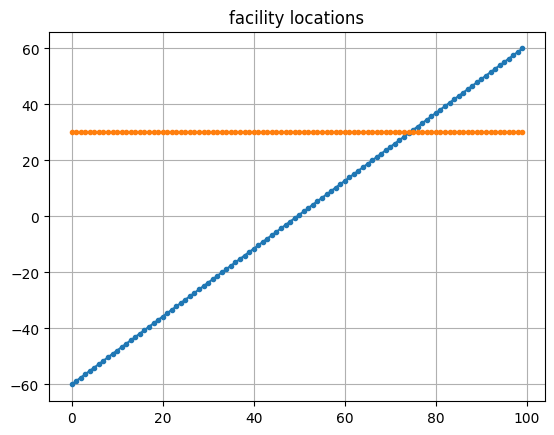

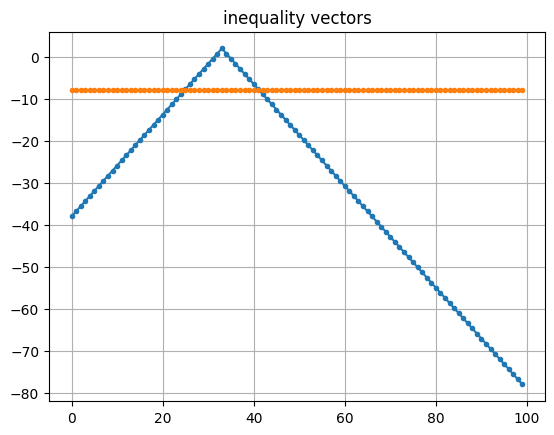

In [ ]:
# create a straight line passing along x-axis through origin
N = 100
x1 = np.linspace(-60, 60, N)
y1 = np.zeros(len(x1))
# x2 = -x1; y2 = -y1
x2 = np.ones(len(x1))*30; y2 = np.zeros(len(y1))*0
curve1 = np.transpose(np.array([x1, y1]))
curve2 = np.transpose(np.array([x2, y2]))
free_energy_data = np.zeros(len(x1))
zeta_data = np.zeros((len(x1), M))
beta = 1
gamma = 0.00001
facLoc = np.array([curve1[0], curve2[0]])
for i in range(N):
    facLoc = np.array([curve1[i], curve2[i]])
    # print(curve2[i])
    free_energy_data[i] = flp.free_energy(facLoc, beta, gamma, Lambda, xi, R, rho, D_scaling, np.array([0, 0, 1, 0]))
    zeta_data[i,:], nouse = flp.ineq_cons(facLoc)
    # print(flp.ineq_cons(facLoc))
plt.figure()
plt.plot(range(N), free_energy_data, marker = '.')
plt.title('free_energy_data')
plt.grid()
plt.figure()
plt.plot(range(N), curve1[:,0], marker = '.')
plt.plot(range(N), curve2[:,0], marker = '.')
plt.title('facility locations')
plt.grid()
plt.show()
plt.figure()
plt.plot(range(N), zeta_data[:,0], marker = '.')
plt.plot(range(N), zeta_data[:,1], marker = '.')
plt.title('inequality vectors')
plt.grid()
plt.show()


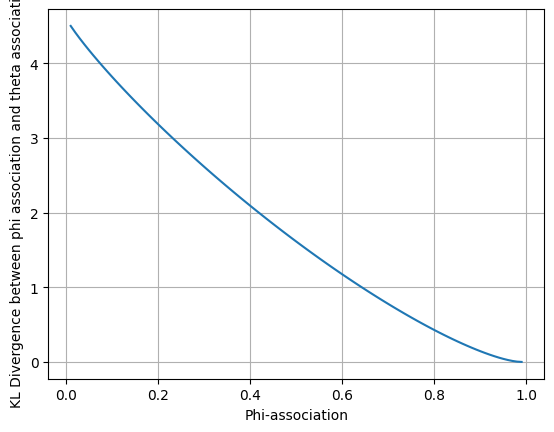

In [94]:
# # test block for functions

# # ===========================
# # function as an argument 
# def apply_function(func, x):
#    return func[0](x), func[1](x)
# def square1(x):
#    return x ** 2
# def sum(x):
#    return x + x
# result = apply_function(np.array([square1, sum]), 3)

# # ===========================
# # penalty function test
# def f(x, xi, beta):
#    tanh = beta*np.tanh(np.sqrt(xi)*x)
#    phi = np.exp(-beta*tanh) / (1 + np.exp(-beta*tanh))
#    logexp = -1/beta*np.log(1 + np.exp(-beta*tanh))
#    sech2 = -xi/np.cosh(xi*x) * phi
#    return tanh, sech2, phi, logexp
# def logsum(beta, x):
#    return 1/beta*np.log(1 + np.exp(beta*x)) - np.maximum(0, x)

# x = np.linspace(-100, 100, 1000)
# tanh1, sech1, phi1, logexp1 = f(x, 0.0000001, 0.10)
# tanh2, sech2, phi2, logexp2 = f(x, 0.0000050, 0.10)
# tanh3, sech3, phi3, logexp3 = f(x, 0.0002500, 0.10)
# tanh4, sech4, phi4, logexp4 = f(x, 0.0125000, 0.10)
# tanh5, sech5, phi5, logexp5 = f(x, 6.2500000, 0.10)

# plt.figure(1)
# plt.plot(x, tanh1)
# plt.plot(x, tanh2)
# plt.plot(x, tanh3)
# plt.plot(x, tanh4)
# plt.plot(x, tanh5)
# plt.title('tanh')
# plt.grid()

# plt.figure(2)
# plt.plot(x, sech1)
# plt.plot(x, sech2)
# plt.plot(x, sech3)
# plt.plot(x, sech4)
# plt.plot(x, sech5)
# plt.title('sech')
# plt.grid()

# plt.figure(3)
# plt.plot(x, phi1)
# plt.plot(x, phi2)
# plt.plot(x, phi3)
# plt.plot(x, phi4)
# plt.plot(x, phi5)
# plt.title('phi')
# plt.grid()

# plt.figure(4)
# plt.plot(x, logexp1)
# plt.plot(x, logexp2)
# plt.plot(x, logexp3)
# plt.plot(x, logexp4)
# plt.plot(x, logexp5)
# plt.title('logexp')
# plt.grid()

# plt.show()

# # ===========================
# # lambda function test
# def calc(x,y):
#    return x*y, x+y

# lambda_calc = lambda x : calc(x, 3)[0]

# print(lambda_calc(3))

# ===========================
# plot KL-divergence function

def kldiv(phi):
   ''' 
   input - phi : variable probability association
   output - kl_distance : returns KL divergence value
   '''
   kl_distance = 0
   theta = 0.99
   kl_distance = phi * np.log(phi/theta) + (1 - phi) * np.log((1 - phi)/(1 - theta))
   return kl_distance

phi = np.linspace(0.01, 0.99, 100)
kldiv_array = kldiv(phi)
plt.plot(phi, kldiv_array)
plt.xlabel('Phi-association')
plt.ylabel('KL Divergence between phi association and theta association')
plt.grid()
plt.show()

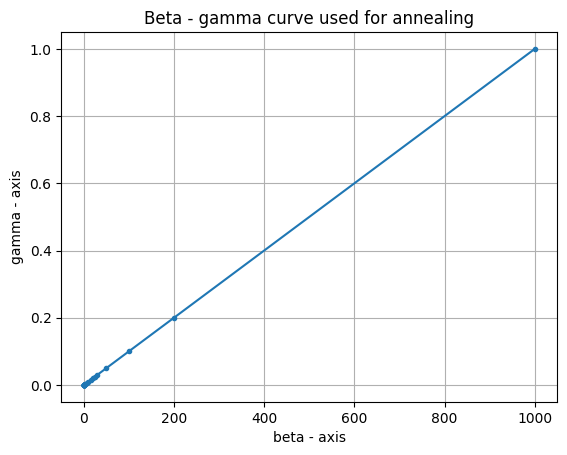

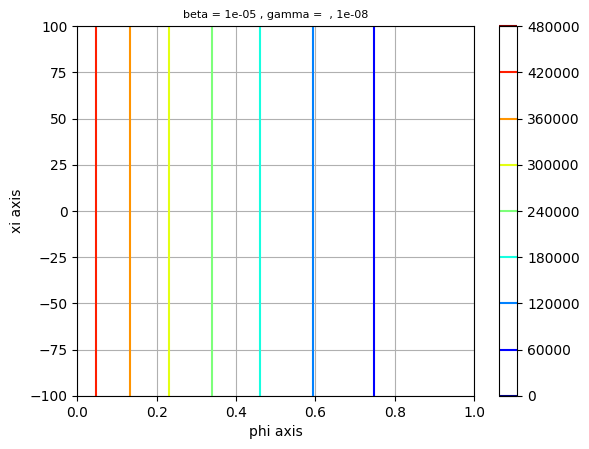

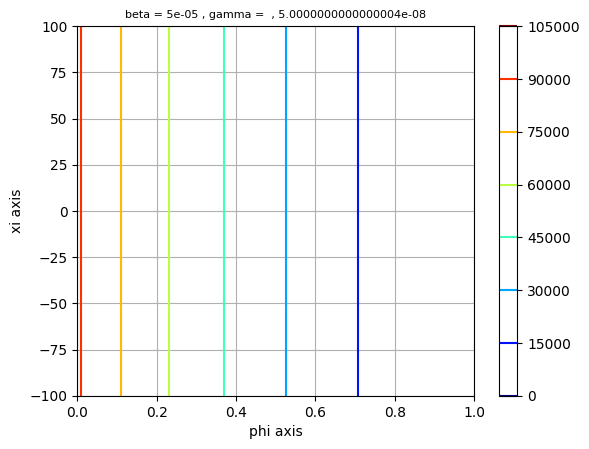

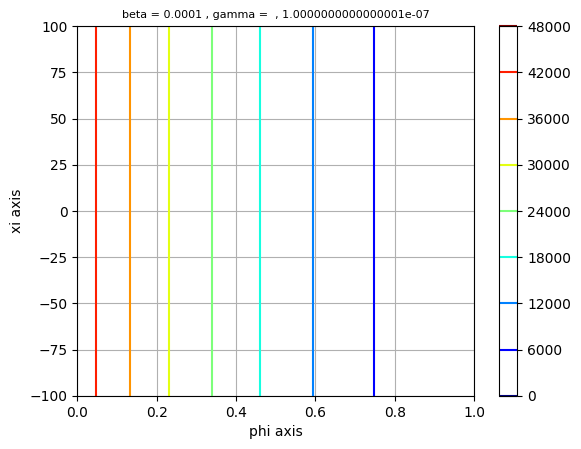

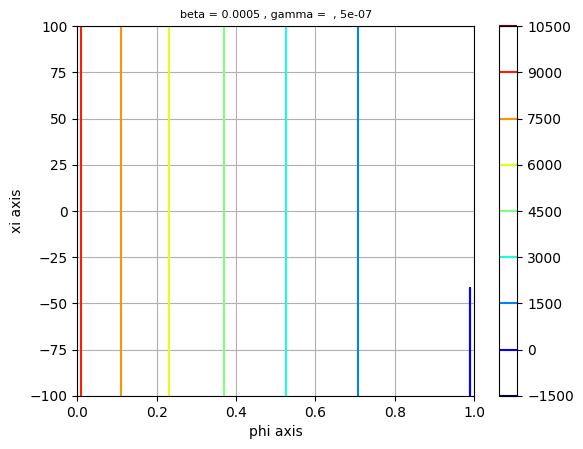

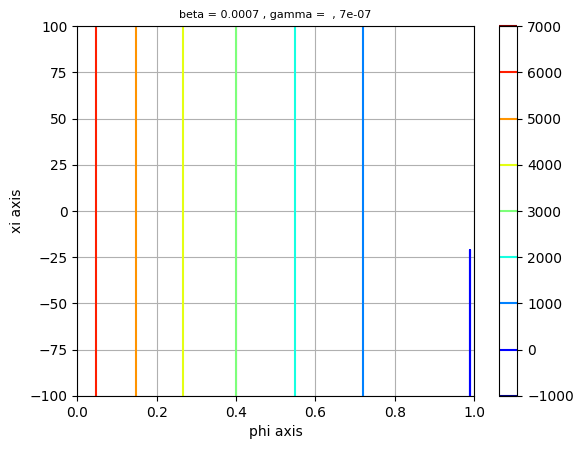

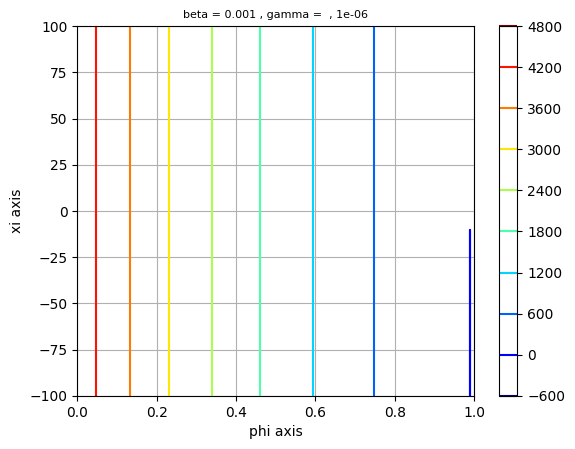

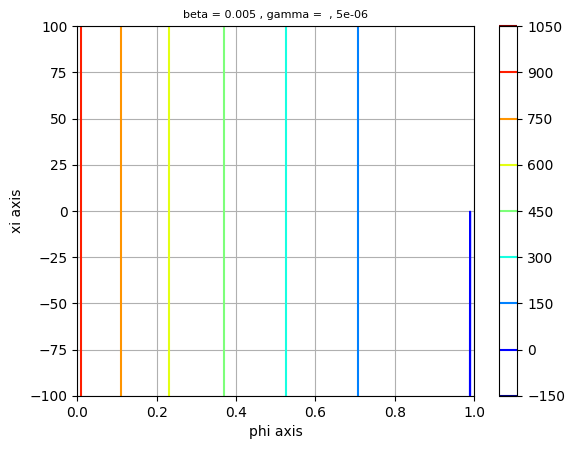

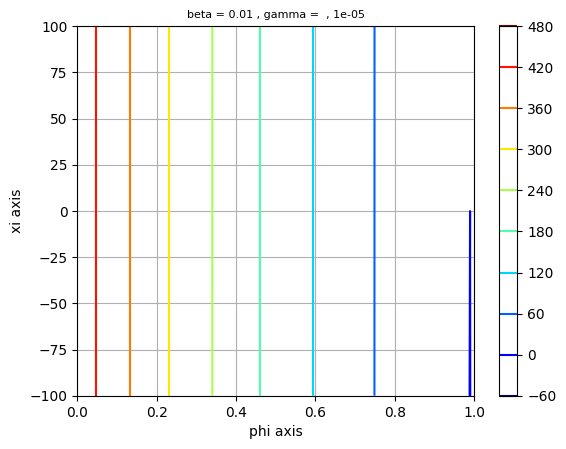

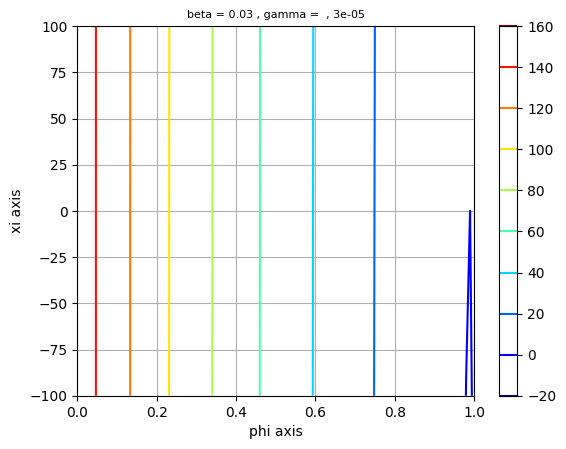

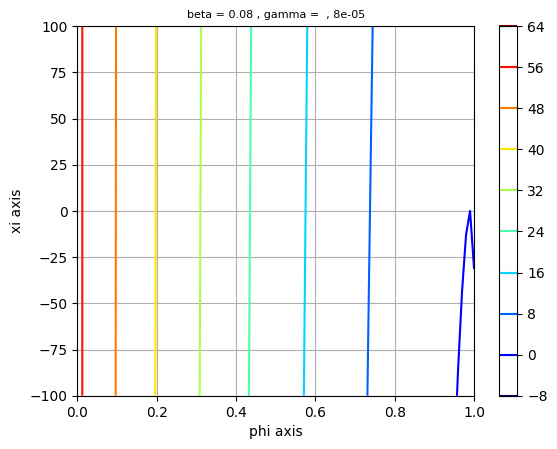

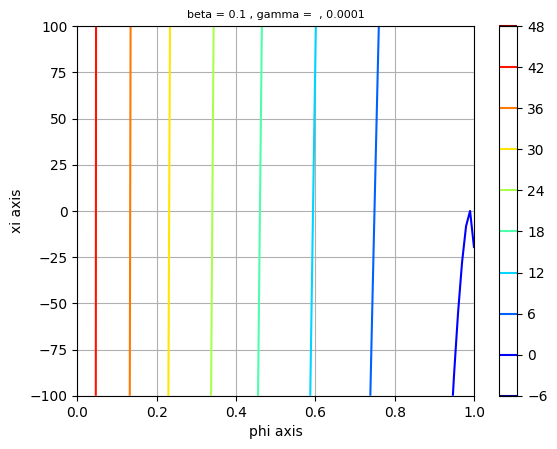

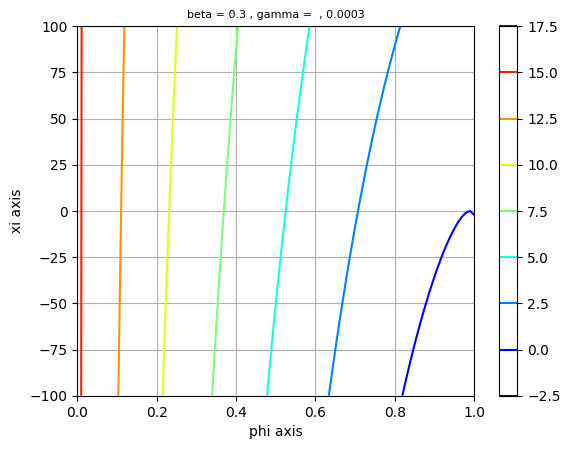

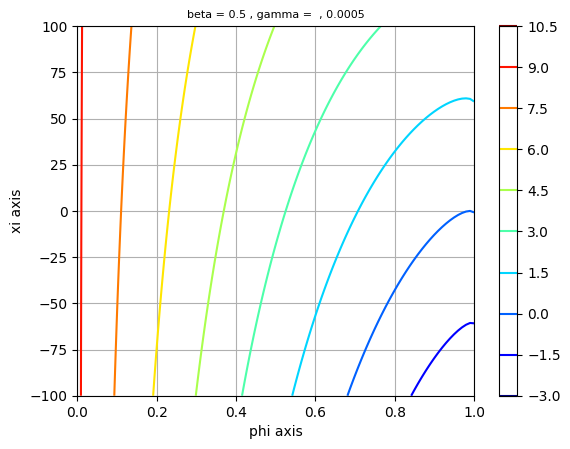

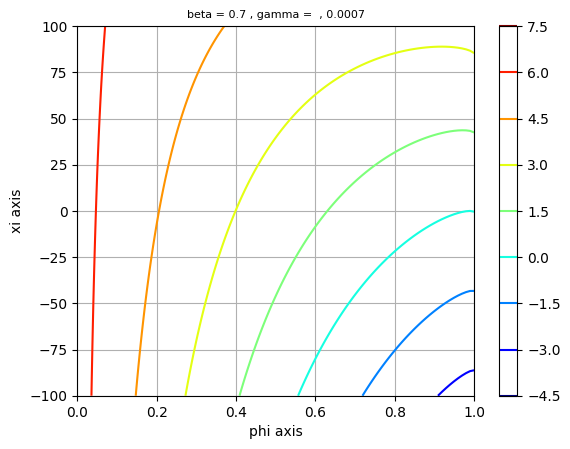

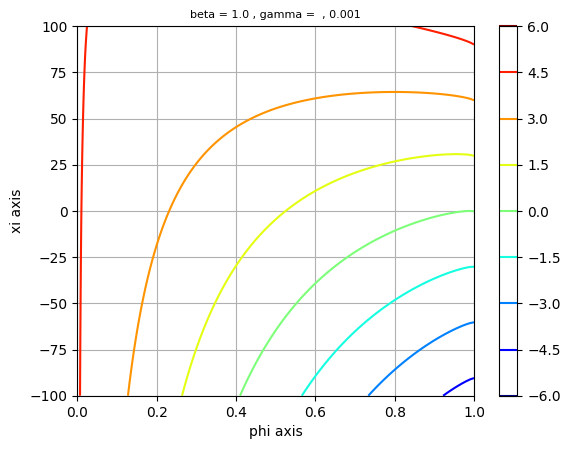

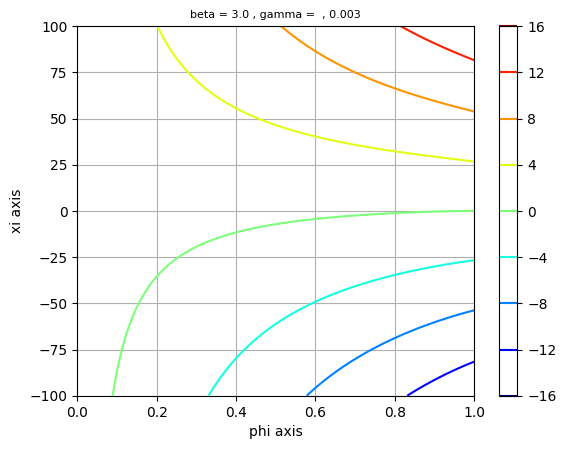

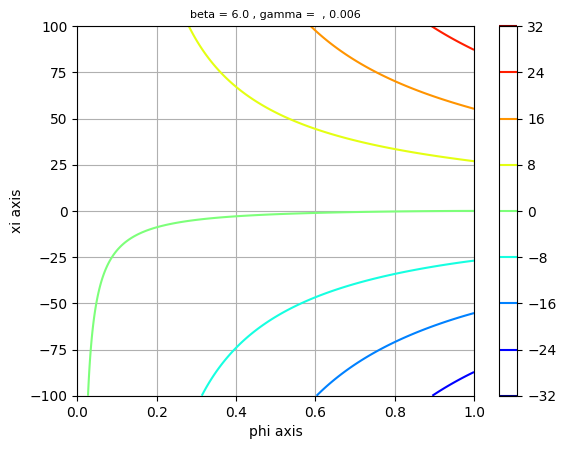

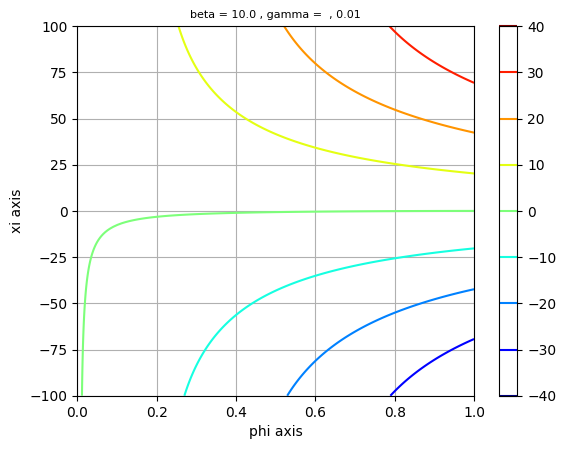

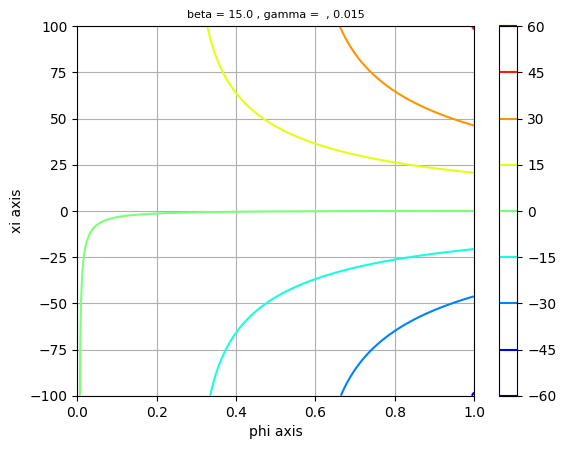

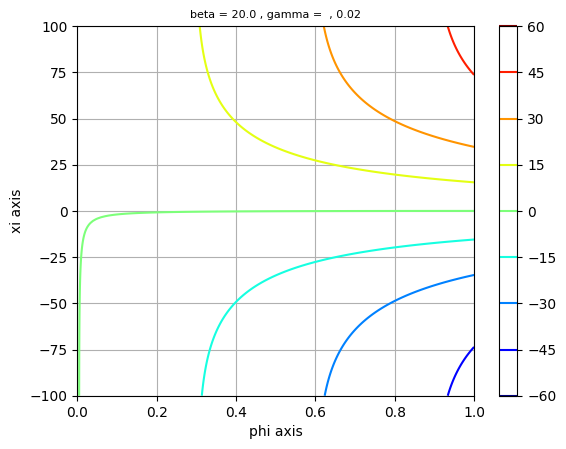

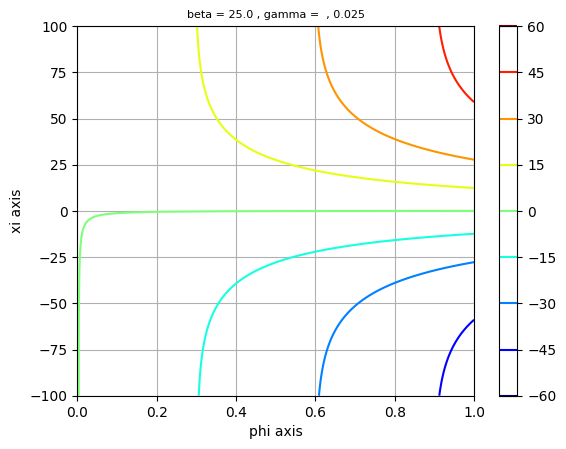

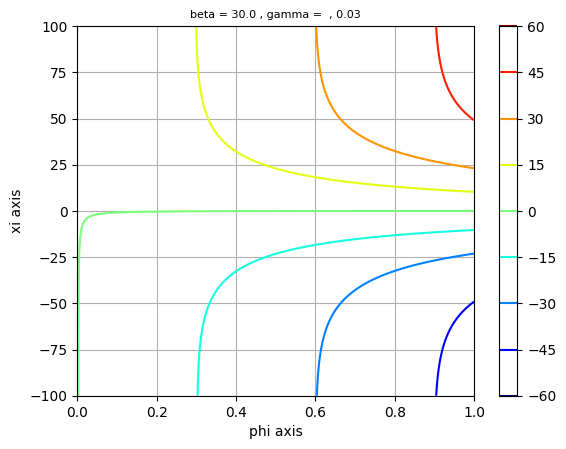

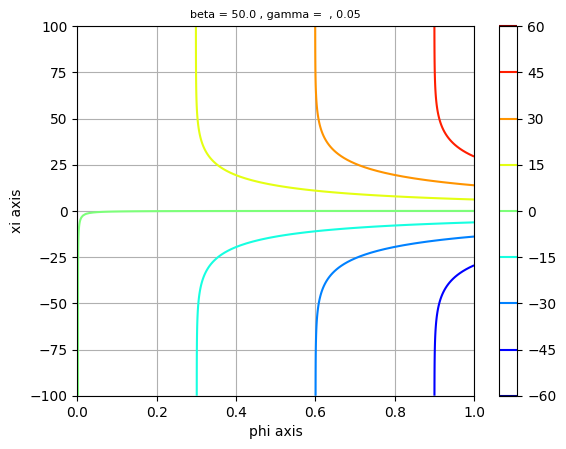

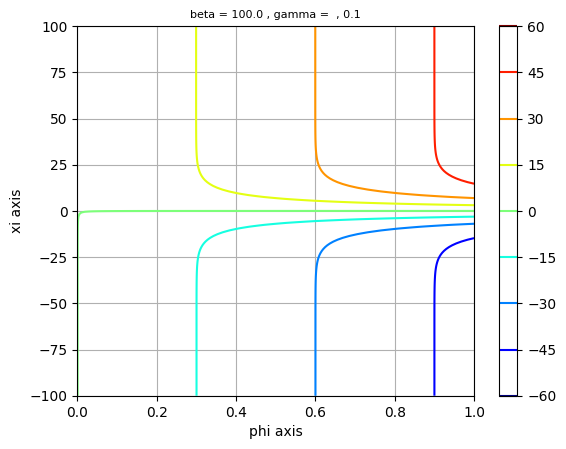

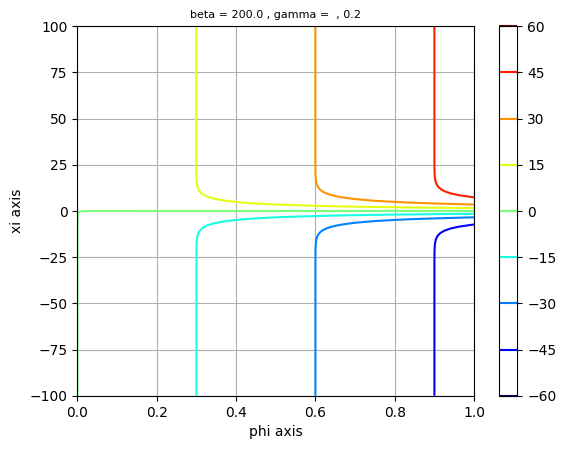

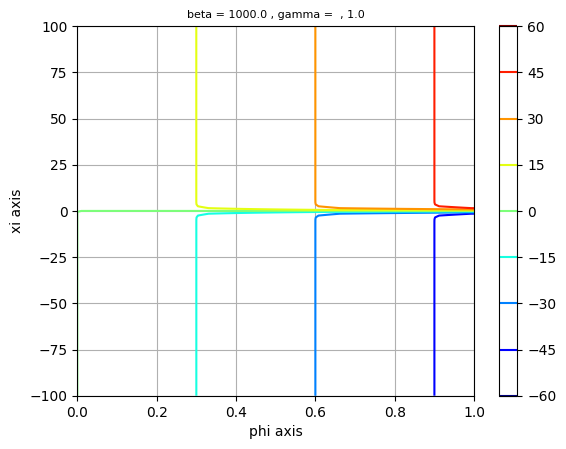

In [163]:
# Plot the inequality constraint lagrangian function

def func(phi, xi, lmd, gamma, beta):
    '''
    input - phi : probability if inequality constraint is satisfied
            xi : inequality constraint variable
            lmd : penalty coefficient
            gamma : penalty shaping parameter
            beta : annealing parameter
    output - None
    '''
    # define constants of the function
    # lmd = 100
    # gamma = np.array([0.001, 0.01, 0.1])
    # beta = gamma**2

    if phi == 0:
        y = lmd * phi * np.tanh(gamma * xi) + 1/beta * (1-phi)*np.log(1-phi)
    elif phi == 1:
        y = lmd * phi * np.tanh(gamma * xi) + 1/beta * phi*np.log(phi)
    elif phi < 1 or phi > 0:
        y = lmd * phi * np.tanh(gamma * xi) + 1/beta * (phi*np.log(phi) + (1-phi)*np.log(1-phi))
    else: 
        raise Exception("phi cannot be outside the interval [0,1]")

    return y

def func1(phi, xi, lmd, gamma, theta, beta):
    '''
    input - phi : probability if inequality constraint is satisfied
            xi : inequality constraint variable
            lmd : penalty coefficient
            gamma : penalty shaping parameter
            beta : annealing parameter
    output - None
    '''
    # define constants of the function
    # lmd = 100
    # gamma = np.array([0.001, 0.01, 0.1])
    # beta = gamma**2

    if phi == 0:
        y = lmd/2 * phi * (1*0 + np.tanh(gamma * xi)) + 1/beta * (1-phi)*np.log((1-phi)/(1-theta))
    elif phi == 1:
        y = lmd/2 * phi * (1*0 + np.tanh(gamma * xi)) + 1/beta * phi*np.log(phi/theta)
    elif phi < 1 or phi > 0:
        y = lmd/2 * phi * (1*0 + np.tanh(gamma * xi)) + 1/beta * (phi*np.log(phi/theta) + (1-phi)*np.log((1-phi)/(1-theta)))
    else: 
        raise Exception("phi cannot be outside the interval [0,1]")

    return y

def betaGammaCurve(betaData):
    '''
    input - betaData : An array of beta annealing parameters
    output - curve : a 2D array representing beta gamma data
    '''
    curve = np.zeros([len(betaData), 2])
    i=0
    for beta in betaData:
        # quadratic curve between beta and gamma
        coeff = 0.001
        # beta_break = 20
        # if beta < beta_break:
        #     gamma=coeff*beta
        # elif beta >= beta_break:
        #     gamma = coeff*beta_break*beta**3/beta_break**3
        gamma = coeff*beta
        # store data
        curve[i]=np.array([beta, gamma])
        i+=1

    return curve

# create a beta-gamma curve manually
curve1 = np.array([[0.00001, 0.001],[0.00005, 0.001],
                   [0.0001, 0.001],[0.0005, 0.001],
                   [0.0007, 0.001],[0.001, 0.001],
                   [0.005, 0.001],[0.01, 0.001],
                   [0.03, 0.001],[0.08, 0.001],
                   [0.1, 0.001],[0.3, 0.001],
                   [0.5, 0.001],[0.7, 0.001],
                   [1, 0.001],[3, 0.001],
                   [3, 0.005],[3, 0.01],
                   [3, 0.05],[3, 0.1],
                   [3, 0.5],[3, 0.9],
                   [3, 1.7],[3, 5],
                   [6, 5],[6, 10],
                   [6, 15],[6, 30],
                   [30, 30],[50, 30],
                   [70, 30],[70, 50],
                   [100, 60],[100, 100]
                ])
# generate a sequence of beta parameters
# betaData = np.linspace(0.0001, 100, 50)
betaData = np.array([0.00001, 0.00005, 0.0001, 0.0005, 0.0007, 0.001, 
                     0.005, 0.01, 0.03, 0.08, 0.1, 0.3, 0.5, 0.7,
                     1, 3, 6, 10, 15, 20, 25, 30, 50, 100, 200, 1000])
# numBeta, beta0, rBeta = 20, 1e-7, 2 # total number of beta iterations, initial beta, geometric ratio
# betaData = [beta0 * rBeta ** i for i in range(numBeta)] # sequence of beta-parameters
curve2 = betaGammaCurve(betaData)

# plot the beta-gamma curve defined above
# plt.figure(1)
# plt.plot(curve1[:,0], curve1[:,1], marker=".")
# plt.xlabel('beta - axis')
# plt.ylabel('gamma - axis')
# plt.title('Beta - gamma curve used for annealing')
# plt.grid()

plt.figure(2)
plt.plot(curve2[:,0], curve2[:,1], marker=".")
plt.xlabel('beta - axis')
plt.ylabel('gamma - axis')
plt.title('Beta - gamma curve used for annealing')
plt.grid()
plt.show()

# define constants
lmd = 100
theta = 0.99
# initialize variable range
phi_min, phi_max, num_phi = 0, 1, 100
xi_min, xi_max, num_xi = -100, 100, 200
phi = np.linspace(phi_min, phi_max, num_phi)
xi = np.linspace(xi_min, xi_max, num_xi)
Phi, Xi = np.meshgrid(phi, xi)
# plot the cost function contour
for point in curve2:
    beta, gamma = point[0], point[1]
    fun = lambda phi, xi : func1(phi, xi, lmd, gamma, theta, beta)
    myfunc = np.vectorize(fun, otypes=[float])
    Y = myfunc(Phi, Xi)

    # plt.figure(1)
    # plt.imshow(Y, extent=[phi_min,phi_max,xi_min,xi_max], cmap=cm.jet, origin='lower')
    # plt.colorbar()
    # plt.xlabel("phi axis")
    # plt.ylabel("xi axis")
    # title_text = "beta = " + str(beta) + " , " + "gamma = " + " , " + str(gamma)
    # plt.title(title_text , fontsize=8)

    plt.figure()
    plt.contour(Phi, Xi, Y, extent=[phi_min, phi_max, xi_min, xi_max], cmap=cm.jet, origin='lower')
    plt.colorbar()
    plt.xlabel("phi axis")
    plt.ylabel("xi axis")
    title_text = "beta = " + str(beta) + " , " + "gamma = " + " , " + str(gamma)
    plt.title(title_text , fontsize=8)
    
    plt.grid()
    plt.show()
